## Special curriculum project


# Topics
**Part I. The low level pipeline**
* Constructing the a mock TOD dataset
* Implement TOD filters (normalisation, polyfilter, PCA and down-sampling?) and mapmaker
* Use implemented pipeline to filter the mock data

**Part II. The high level pipeline**
* Compute an auto and cross power spectrum, do you see any differences?
* A primer on CO models
* Perform an MCMC and grid search assuming you have a flat CO emission model
* Perform a two-parameter CO model MCMC and grid search
* Can we separate the two models? Which one fits best? 

In [109]:
import numpy as np 
import h5py 
import matplotlib.pyplot as plt
from dataclasses import dataclass


In [380]:
with h5py.File("../data/level2_sim/fullseason_b3/co6/co6_001481703.h5", "r") as infile:
    pointing = infile["point_cel"][()]
    
    # Extract RA and Dec coordinates
    ra = pointing[0, :, 0] # Flatten all 19 detectors into one
    dec = pointing[0, :, 1]
    time = infile["time"][()] * 24 * 3600 # MJD to seconds
    time -= time[0] # Time since start of scan in seconds
    dt = time[1] - time[0]
    print(infile.keys())
    


<KeysViewHDF5 ['AB_aliasing', 'C_template_lowres', 'Gain', 'N_freqs_in_bin', 'Pcold', 'Phot', 'Thot', 'Thot_times', 'Tsys', 'Tsys_lowres', 'acceptrate', 'cal_method', 'chi2', 'decimation_nu', 'decimation_time', 'el_az_amp', 'el_az_amp_bidir', 'feature', 'feeds', 'freq_bin_centers', 'freq_bin_centers_lowres', 'freq_bin_edges', 'freq_bin_edges_lowres', 'freqmask', 'freqmask_full', 'freqmask_full_aftermasking', 'freqmask_reason', 'freqmask_reason_string', 'git_hash', 'hk_airtemp', 'hk_cryostat_pressure', 'hk_cryostat_temp1', 'hk_cryostat_temp2', 'hk_cryostat_temp3', 'hk_cryostat_temp4', 'hk_cryostat_temp5', 'hk_cryostat_temp6', 'hk_dewtemp', 'hk_humidity', 'hk_mjd', 'hk_pressure', 'hk_rain', 'hk_winddir', 'hk_windspeed', 'is_sim', 'is_wn_sim', 'l1_filepath', 'leak_aliasing', 'mask_temporal', 'mean_tp', 'mjd_start', 'n_cal', 'n_nan', 'n_pca_comp', 'n_pca_feed_comp', 'n_spikes', 'obsid', 'params', 'pca_ampl', 'pca_comp', 'pca_eigvals', 'pca_feed_ampl', 'pca_feed_comp', 'pca_feed_eigvals', '

In [201]:
@dataclass
class Simcube():
    """Simple data storage object for simulation cube"""
    
    def read(self, path: str):
        """Read data from HDF5 file

        Args:
            path (string): Path to input HDF5 simulation file.
        """
        with h5py.File(path, "r") as infile:
            for key, value in infile.items():    
                self.__setattr__(key, value[()])
    
    def write(self, path: str):
        """Write data to HDF5 file

        Args:
            path (string): Path to HDF5 output simulation file.
        """
        with h5py.File(path, "w") as outfile:
            for key, value in self.__dict__.items():    
                outfile.create_dataset(key, data = value)
        

In [337]:
path = "../data/simulation/simcube.h5"

simcube = Simcube()
simcube.read(path)

simcube.simulation = simcube.simulation * 1e-6 # muK to K

# Simulation cube now has all the same attributes as the original HDF5 file
print(simcube.__dict__.keys())

# Transfor to CO6 (Field 3) center
field_center = (226.0, 55.00)

simcube.x_bin_centers = simcube.x_bin_centers / np.abs(np.cos(np.radians(field_center[1]))) + field_center[0]
simcube.y_bin_centers = simcube.y_bin_centers + field_center[1]
simcube.x_bin_edges = simcube.x_bin_edges  / np.abs(np.cos(np.radians(field_center[1])))  + field_center[0]
simcube.y_bin_edges = simcube.y_bin_edges + field_center[1]

dra = np.diff(simcube.x_bin_centers)[0] / np.abs(np.cos(np.radians(field_center[1]))) # accounting for physical degrees at non-zero declination
ddec = np.diff(simcube.y_bin_centers)[0]


dict_keys(['frequency_bin_centers', 'frequency_bin_edges', 'k', 'model_name', 'model_params', 'power_spectrum_smoothed', 'power_spectrum_unsmoothed', 'seed', 'simulation', 'x_bin_centers', 'x_bin_edges', 'y_bin_centers', 'y_bin_edges'])


In [338]:
Ntime = ra.shape[-1]
Nx, Ny = simcube.x_bin_centers.size, simcube.y_bin_centers.size

# Pointing index
idx_ra = np.round((ra - simcube.x_bin_edges.min()) / dra).astype(np.int32)
idx_dec = np.round((dec - simcube.y_bin_edges.min()) / ddec).astype(np.int32)

idx_ra = np.ma.masked_array(idx_ra, mask = np.logical_or(idx_ra < 0, idx_ra >= Nx)) 
idx_dec = np.ma.masked_array(idx_dec, mask = np.logical_or(idx_dec < 0, idx_dec >= Ny)) 


pointing_idx = idx_ra * Ny + idx_dec

pointing_matrix = np.zeros((ra.shape[-1], Nx * Ny))
pointing_matrix[np.arange(Ntime), pointing_idx] = 1

In [339]:
simcube.simulation[0, 0, ...]

array([[6.99902466e-06, 1.20443574e-05, 7.02347506e-06, ...,
        8.63409610e-09, 1.04818376e-07, 1.38471489e-06],
       [4.10733855e-06, 6.98533358e-06, 4.06084428e-06, ...,
        3.60313268e-09, 6.46781046e-08, 8.37847949e-07],
       [8.47851084e-07, 1.42554950e-06, 9.73508577e-07, ...,
        6.73243683e-09, 1.87647018e-08, 1.88161152e-07],
       ...,
       [2.39649194e-06, 7.10144877e-06, 1.19963070e-05, ...,
        6.95396452e-08, 1.76252229e-07, 5.12425800e-07],
       [1.86800469e-06, 4.05822357e-06, 5.36686912e-06, ...,
        1.94937897e-08, 6.12216056e-08, 3.72326838e-07],
       [4.24517521e-06, 7.46267551e-06, 4.90942011e-06, ...,
        1.24080977e-08, 7.39437311e-08, 8.35015896e-07]], dtype=float32)

221.64138301094727 230.3586169890527


Text(0, 0.5, 'Declination [deg]')

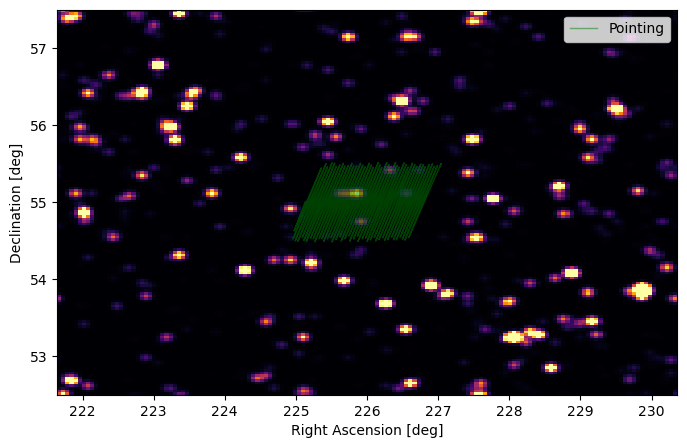

In [340]:
fig, ax = plt.subplots(figsize = (8, 5))

X, Y = np.meshgrid(simcube.x_bin_centers, simcube.y_bin_centers)
img = ax.pcolormesh(
    X,
    Y,
    simcube.simulation[0, 0, ...],
    cmap = "inferno",
    vmax = simcube.simulation[0, 0, ...].max() * 0.1
    
)
print(simcube.x_bin_edges.min(), simcube.x_bin_edges.max())
_ = ax.plot(ra.T, dec.T, lw = 1, alpha = 0.5, color = "g", label = "Pointing")
ax.set_xlim(simcube.x_bin_edges.min(), simcube.x_bin_edges.max())
ax.set_ylim(simcube.y_bin_edges.min(), simcube.y_bin_edges.max())

ax.legend()
ax.set_xlabel("Right Ascension [deg]")
ax.set_ylabel("Declination [deg]")



In [341]:
signal_tod = simcube.simulation[:, :, idx_ra, idx_dec]
signal_tod.shape

(4, 128, 20100)

Text(0, 0.5, 'Signal [$\\mu K$]')

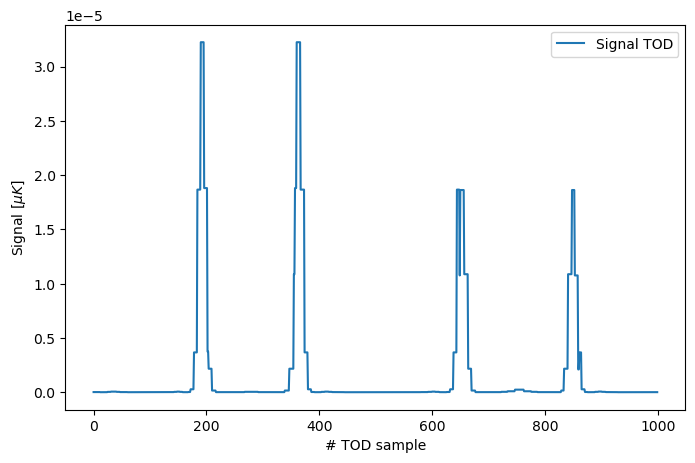

In [342]:
fig, ax = plt.subplots(figsize = (8, 5))

ax.plot(np.arange(Ntime)[:1000], signal_tod[0, 0, :1000], label = "Signal TOD")
ax.legend()
ax.set_xlabel(r"# TOD sample")
ax.set_ylabel(r"Signal [$\mu K$]")

In [343]:
def one_over_f(f, sigma0, fknee, alpha):
    """Power spectral density model of 1/f correlated noise

    Args:
        f: frequency
        sigma0: White noise level
        fknee: Knee frequency of 1/f
        alpha: Slope of 1/f

    """
    return sigma0 ** 2 * (1 + (np.abs(f) / fknee) ** alpha)

In [381]:
np.random.seed(42)

f = np.fft.fftfreq(Ntime, dt)
sigma0, fknee, alpha = 0.34, 8, -1
psd_corr = one_over_f(f, sigma0, fknee, alpha)
psd_corr[f == 0] = 0 # Removing the singular frequency

white_noise = np.random.normal(0, 1, signal_tod.shape)
fft_noise = np.fft.fft(white_noise, axis = -1)

correlated_noise = np.fft.ifft(np.sqrt(psd_corr)[None, None, :] * fft_noise, axis = -1).real

white_noise = white_noise * sigma0

#np.sqrt(np.var((correlated_noise[:-1] - correlated_noise[1:]) / 2, axis = -1, ddof = 1)), np.sqrt(np.var((white_noise[:-1] - white_noise[1:]) / 2, ddof = 1, axis = -1))


/var/folders/gf/7myrg_894l96llyf6x7lqj0h0000gp/T/ipykernel_34259/678446448.py:11: RuntimeWarning: divide by zero encountered in reciprocal
  return sigma0 ** 2 * (1 + (np.abs(f) / fknee) ** alpha)


Text(0.5, 0, '# time sample')

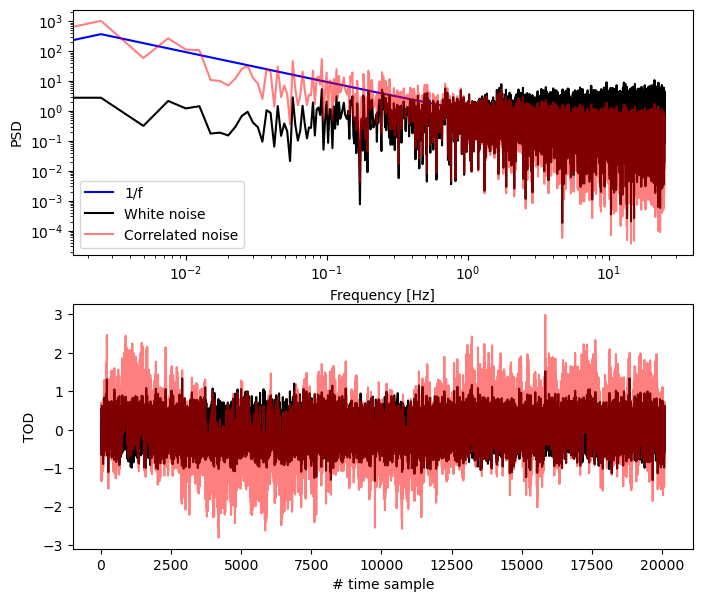

In [429]:
fig, ax = plt.subplots(2, 1, figsize = (8, 7))
ax[0].plot(f[:f.size // 2], psd_corr[:f.size // 2], label = "1/f", color = "blue")
ax[0].plot(f[:f.size // 2], np.abs(fft_noise)[0, 0, :f.size // 2] ** 2 / Ntime, alpha = 1, label = "White noise", color = "k")
ax[0].plot(f[:f.size // 2], psd_corr[:f.size // 2] * np.abs(fft_noise)[0, 0, :f.size // 2] ** 2 / Ntime, label = "Correlated noise", alpha = 0.5, color = "red")
ax[0].legend()
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_ylabel("PSD")
ax[0].set_xlabel("Frequency [Hz]")

ax[1].plot(np.arange(Ntime), white_noise[0, 0, :], alpha = 1, label = "White noise", color = "k")
ax[1].plot(np.arange(Ntime), correlated_noise[0, 0, :], label = "Correlated noise", alpha = 0.5, color = "red")
ax[1].set_ylabel("TOD")
ax[1].set_xlabel("# time sample")



In [378]:
boost = 1e7 # Rediculous boost
Tsys = 44 # K
signal = boost * (signal_tod - simcube.simulation.mean()) / Tsys
data = correlated_noise + signal


Text(0.5, 0, '# time sample')

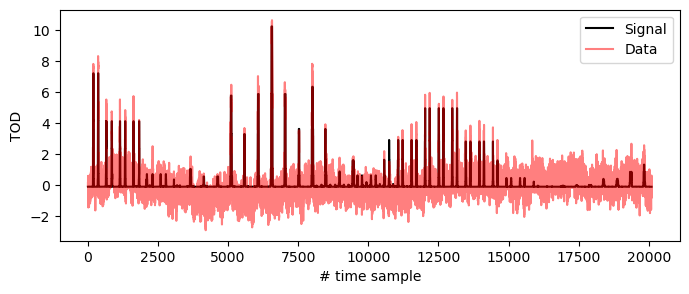

In [379]:
fig, ax = plt.subplots(figsize = (8, 3))

ax.plot(np.arange(Ntime), signal[0, 0, :], label = "Signal", alpha = 1, color = "k")
ax.plot(np.arange(Ntime), data[0, 0, :], label = "Data", alpha = 0.5, color = "red")
ax.legend()
ax.set_ylabel("TOD")
ax.set_xlabel("# time sample")


In [419]:
systematics = np.sin(2 * np.pi * np.arange(4 * 128) / 100).reshape(4, 128)
systematics = systematics[:, :, None] * (np.sin(2 * np.pi * np.arange(Ntime) / 1000) + np.cos(2 * np.pi * np.arange(Ntime) / 10000))[None, None, :]

(4, 128, 20100) (4, 128, 20100)


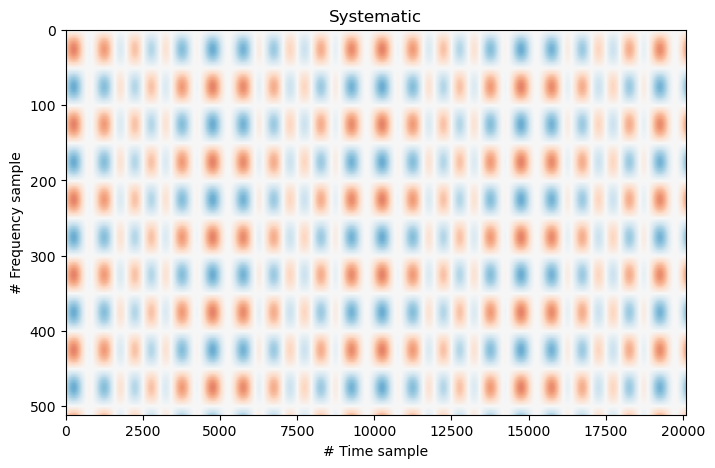

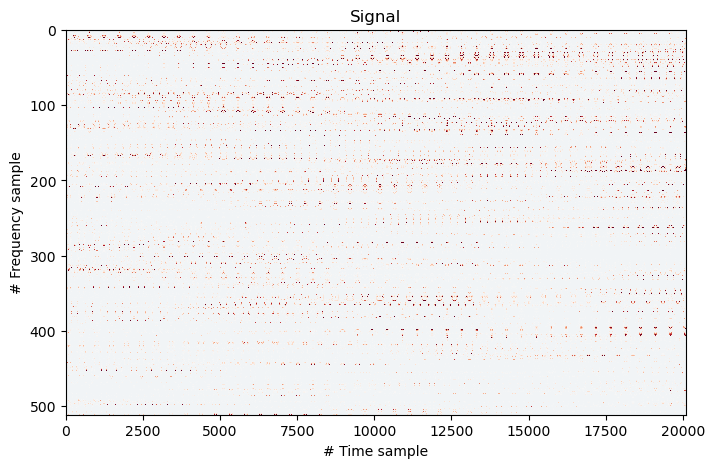

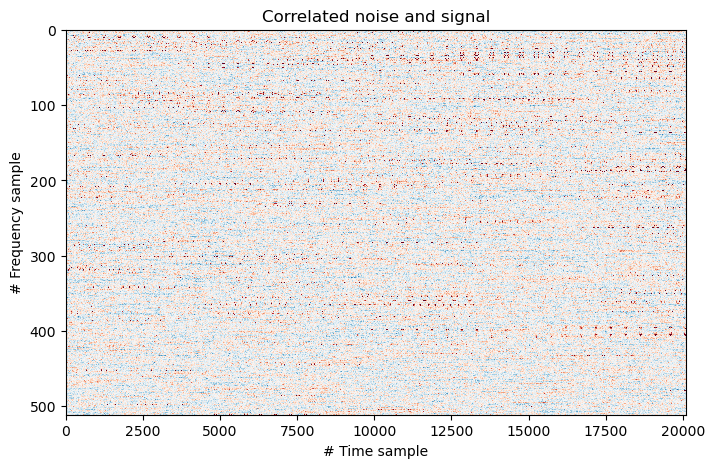

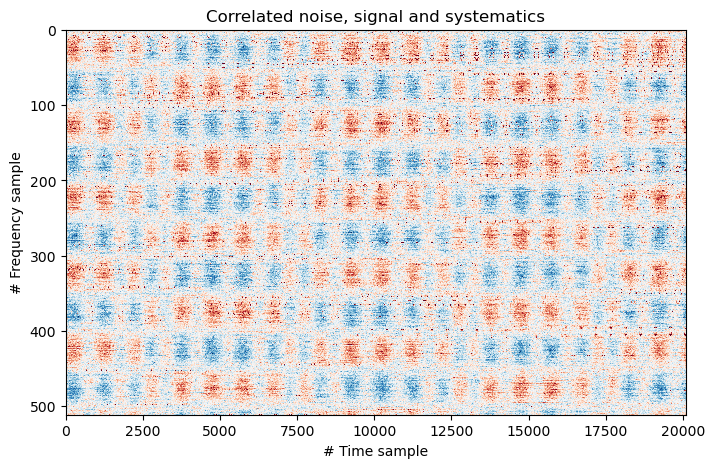

In [428]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.set_title("Systematic")
ax.imshow(
    systematics.reshape(4 * 128, Ntime),
    cmap = "RdBu_r",
    interpolation = "none",
    aspect = "auto",
    vmin = -4, 
    vmax = 4,
)
ax.set_ylabel("# Frequency sample")
ax.set_xlabel("# Time sample")

fig, ax = plt.subplots(figsize = (8, 5))
ax.set_title("Signal")

ax.imshow(
    (signal).reshape(4 * 128, Ntime),
    cmap = "RdBu_r",
    interpolation = "none",
    aspect = "auto",
    vmin = -4, 
    vmax = 4,
)

ax.set_ylabel("# Frequency sample")
ax.set_xlabel("# Time sample")

fig, ax = plt.subplots(figsize = (8, 5))
ax.set_title("Correlated noise and signal")

ax.imshow(
    (data).reshape(4 * 128, Ntime),
    cmap = "RdBu_r",
    interpolation = "none",
    aspect = "auto",
    vmin = -4, 
    vmax = 4,
)
ax.set_ylabel("# Frequency sample")
ax.set_xlabel("# Time sample")

fig, ax = plt.subplots(figsize = (8, 5))
ax.set_title("Correlated noise, signal and systematics")

ax.imshow(
    (data + systematics).reshape(4 * 128, Ntime),
    cmap = "RdBu_r",
    interpolation = "none",
    aspect = "auto",
    vmin = -4, 
    vmax = 4,
)
ax.set_ylabel("# Frequency sample")
ax.set_xlabel("# Time sample")

print(data.shape, systematics.shape)


### Time to analyse some data...